In [1]:
import pymc3 as pm
import numpy as np
import scipy.io as sio
import glob
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import math
from itertools import cycle

from matplotlib import rc
rc("font", family="serif", size=14)
rc("text", usetex=True)


%matplotlib inline

color_cycle = cycle(['g', 'b', 'c', 'm', 'y', 'k'])

# The omnipotent rat

This model assumes that the rat:
* can discern with 100% accuracy the direction of the coherent motion no matter what the noise

In this case, there is no need for the rat to supplement any prior information into the stimulus, since the rat is able to discern the coherent direction with 100% accuracy. Thus we have:

$$ p(R) = 1 $$ 

for $c>0$ and $$p(R) = 0$$ for $c<0$.

In [18]:
def load_RDK_data_from_mat_to_pandas(filename):
    mat = sio.loadmat(filename)
    mat = mat['temp_obj'][0]
    field_names = mat.dtype.names
    data = mat[0]
    data_dict = dict(zip(field_names,data))
    for key in data_dict:
        data_dict[key] = data_dict[key].squeeze()

    return data_dict

/home/adam/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


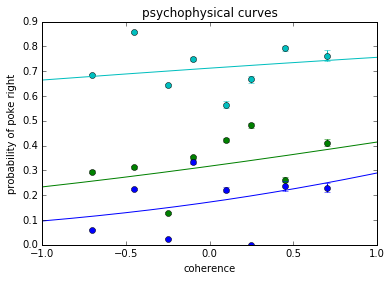

In [19]:
rat_name = 'miley0'
data = load_RDK_data_from_mat_to_pandas('/home/adam/Documents/DATA/RDK/Behavior_1/Adam20170516/'+rat_name+'_session1.spd')
data = pd.DataFrame.from_dict(data)
data.index.name = 'trial'

# this makes psychophysical curves

plt.figure()
plt.title('psychophysical curves')
plt.xlabel('coherence')
plt.ylabel('probability of poke right')
for p in data.prior_right.unique():
    cc = next(color_cycle)
    
    data_p = data.loc[lambda x: x.prior_right == p] # pick out data for the given prior
    coherence_means = data_p.groupby(['coherence'],as_index=False).response_right.mean()
    
    # std of estimation for a binary variable is sqrt(p(1-p)/n)
    yerrors = np.ravel(coherence_means.apply(lambda x: x*(1-x)).response_right)
    yerrors = yerrors/np.ravel(data_p['coherence'].value_counts())
    plt.errorbar(coherence_means.coherence,coherence_means.response_right,yerr = yerrors,fmt='o',color=cc)
    
    # logistic regression to fit psychophysical curve
    log_model = linear_model.LogisticRegression(C=1e20,max_iter=100,penalty='l2')
    log_model.fit(X = data_p.coherence.reshape(data_p.coherence.count(),1), y = np.ravel(data_p.response_right))
    
    # plot values psych curves
    x_val = np.linspace(-1,1,200).reshape(200,1)
    plt.plot(x_val,log_model.predict_proba(x_val)[:,1],color=cc)

In [ ]:
# this runs mcmc on the data

response_data = np.ravel(data.response_right)
coherences = np.ravel(data.coherence)
unique_coherences = np.unique(coherences);




@as_op(itypes=[tt.lscalar], otypes=[tt.lscalar])
def coin_prob(coherence_val):
    







with pm.Model() as model:
    slope_ = pm.Uniform('a',-10,10)
    intercept_ = pm.Uniform('b',-1,1)

with model:
    coin_prob
    
with model:
    observation = pm.Bernoulli("obs",coin_probs_over_time,value = response_data,observed=True)






slope_ = pm.Uniform('a',-10,10)
intercept_ = pm.Uniform('b',-1,1)
print slope_.random()

@pm.deterministic
def coin_probs_over_time(s_ = slope_, i_ = intercept_, uc = unique_coherences,c = coherences):
    out = np.zeros(len(c))
    for k in range(uc.size):       
        out[np.where(c==uc[k])]=1/( 1+math.exp(-4*s_*(uc[k]- i_)) )
    return out

observation = pm.Bernoulli("obs",coin_probs_over_time,value=response_data,observed=True)



M = pm.Model([slope_,intercept_, coin_probs_over_time,observation])
mcmc = pm.MCMC(M)
mcmc.sample(40000,10000)
    
    